In [57]:
# Cell 1: Setup and Species Selection
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from pathlib import Path
import sys

# Load your cleaned data (you already have this)
print("Loading cleaned data...")
sys.path.append('../src')
from data_io import load_excel_data, clean_observations

data_path = Path('../data/raw/Observations 2012-2025.xlsx')
data_dict = load_excel_data(data_path)
df_clean = clean_observations(data_dict['observations'])
df_species = data_dict['species']

# Identify interesting species
def identify_interesting_species(df_clean, top_n=10):
    """Identify species with interesting patterns"""
    
    # Most abundant species
    species_abundance = df_clean.groupby('species_name')['individual_count'].sum().sort_values(ascending=False)
    
    # Species with highest year-to-year variation
    species_variation = df_clean.groupby(['year', 'species_name'])['individual_count'].sum().unstack().std().sort_values(ascending=False)
    
    # Species present in most years (consistency)
    species_presence = df_clean.groupby(['year', 'species_name'])['individual_count'].sum().unstack()
    species_consistency = (species_presence > 0).sum().sort_values(ascending=False)
    
    print("Top 10 Most Abundant Species:")
    print(species_abundance.head(10))
    
    print("\nTop 10 Most Variable Species:")
    print(species_variation.head(10))
    
    print("\nTop 10 Most Consistent Species:")
    print(species_consistency.head(10))
    
    # Select 4-6 interesting species for detailed analysis
    interesting_species = [
        species_abundance.index[0],  # Most abundant
        species_variation.index[0],  # Most variable
        species_abundance.index[5],  # Moderately abundant but interesting
        species_consistency.index[0], # Most consistent
    ]
    
    # Remove duplicates and ensure we have unique species
    interesting_species = list(dict.fromkeys(interesting_species))[:4]
    
    print(f"\nSelected species for detailed analysis: {interesting_species}")
    return interesting_species

interesting_species = identify_interesting_species(df_clean)

Loading cleaned data...
Loading data from ../data/raw/Observations 2012-2025.xlsx
Loaded 86 species
Loaded 651 GPS points
Converting count columns to numeric
Loaded 114497 observation records
Data Cleaning
Starting with 114497 records
⚠ Found 5 negative wind values - setting to NaN
Removed 4 records with zero/negative counts
Final dataset: 114493 records
  Years: 2014.0 - 2025.0
  Unique species: 102
  Unique transects: 72
  Unique observers: 42
Top 10 Most Abundant Species:
species_name
Quiscale merle                114356.000000
Sucrier à ventre jaune         90260.000000
Elénie siffleuse               61802.000000
Tourterelle à queue carrée     60901.000000
Sporophile rougegorge          60209.666667
Sporophile cici                43824.000000
Tyran gris                     40408.000000
Saltator gros-bec              31566.000000
Viréo à moustaches             28069.000000
Merle à lunettes               27682.000000
Name: individual_count, dtype: float64

Top 10 Most Variable Specie

In [58]:
# Cell 2: Species Trend Analysis
def analyze_species_trends(df_clean, species_list):
    """Analyze trends for selected species with confidence intervals"""
    
    results = {}
    
    for species in species_list:
        print(f"\n--- Analyzing {species} ---")
        
        # Get annual data for this species
        species_data = df_clean[df_clean['species_name'] == species]
        annual_counts = species_data.groupby('year')['individual_count'].sum()
        
        # Fill missing years with 0 (species was not recorded)
        complete_years = df_clean[(df_clean['year'] >= 2015) & (df_clean['year'] <= 2024)]['year'].unique()
        all_years = pd.Series(complete_years).sort_values()
        annual_counts = annual_counts.reindex(all_years, fill_value=0)
        
        # Calculate confidence intervals using bootstrap
        n_bootstrap = 1000
        boot_estimates = []
        
        for _ in range(n_bootstrap):
            # Bootstrap resample within each year
            boot_sample = []
            for year in all_years:
                year_data = species_data[species_data['year'] == year]
                if len(year_data) > 0:
                    boot_year = year_data.sample(n=len(year_data), replace=True)
                    boot_sample.append(boot_year['individual_count'].sum())
                else:
                    boot_sample.append(0)
            boot_estimates.append(boot_sample)
        
        boot_estimates = np.array(boot_estimates)
        ci_lower = np.percentile(boot_estimates, 2.5, axis=0)
        ci_upper = np.percentile(boot_estimates, 97.5, axis=0)
        
        # Fit trend model (only if we have enough non-zero years)
        non_zero_years = annual_counts[annual_counts > 0]
        if len(non_zero_years) >= 3:
            X = sm.add_constant(non_zero_years.index)
            y = non_zero_years.values
            model = sm.OLS(y, X).fit()
            trend_slope = model.params[1]
            trend_p = model.pvalues[1]
        else:
            trend_slope = 0
            trend_p = 1.0
        
        results[species] = {
            'annual_counts': annual_counts,
            'ci_lower': ci_lower,
            'ci_upper': ci_upper,
            'trend_slope': trend_slope,
            'trend_p': trend_p,
            'presence_years': len(non_zero_years),
            'total_count': annual_counts.sum()
        }
        
        print(f"  Total count: {annual_counts.sum()}")
        print(f"  Years present: {len(non_zero_years)}/10")
        print(f"  Trend slope: {trend_slope:.2f} (p={trend_p:.3f})")
    
    return results

species_results = analyze_species_trends(df_clean, interesting_species)


--- Analyzing Quiscale merle ---
  Total count: 100788.0
  Years present: 10/10
  Trend slope: -9.70 (p=0.925)

--- Analyzing Sporophile cici ---
  Total count: 38861.0
  Years present: 10/10
  Trend slope: -44.79 (p=0.508)

--- Analyzing Frégate superbe ---
  Total count: 1353.0
  Years present: 10/10
  Trend slope: 13.15 (p=0.090)


Plotting 3 species...


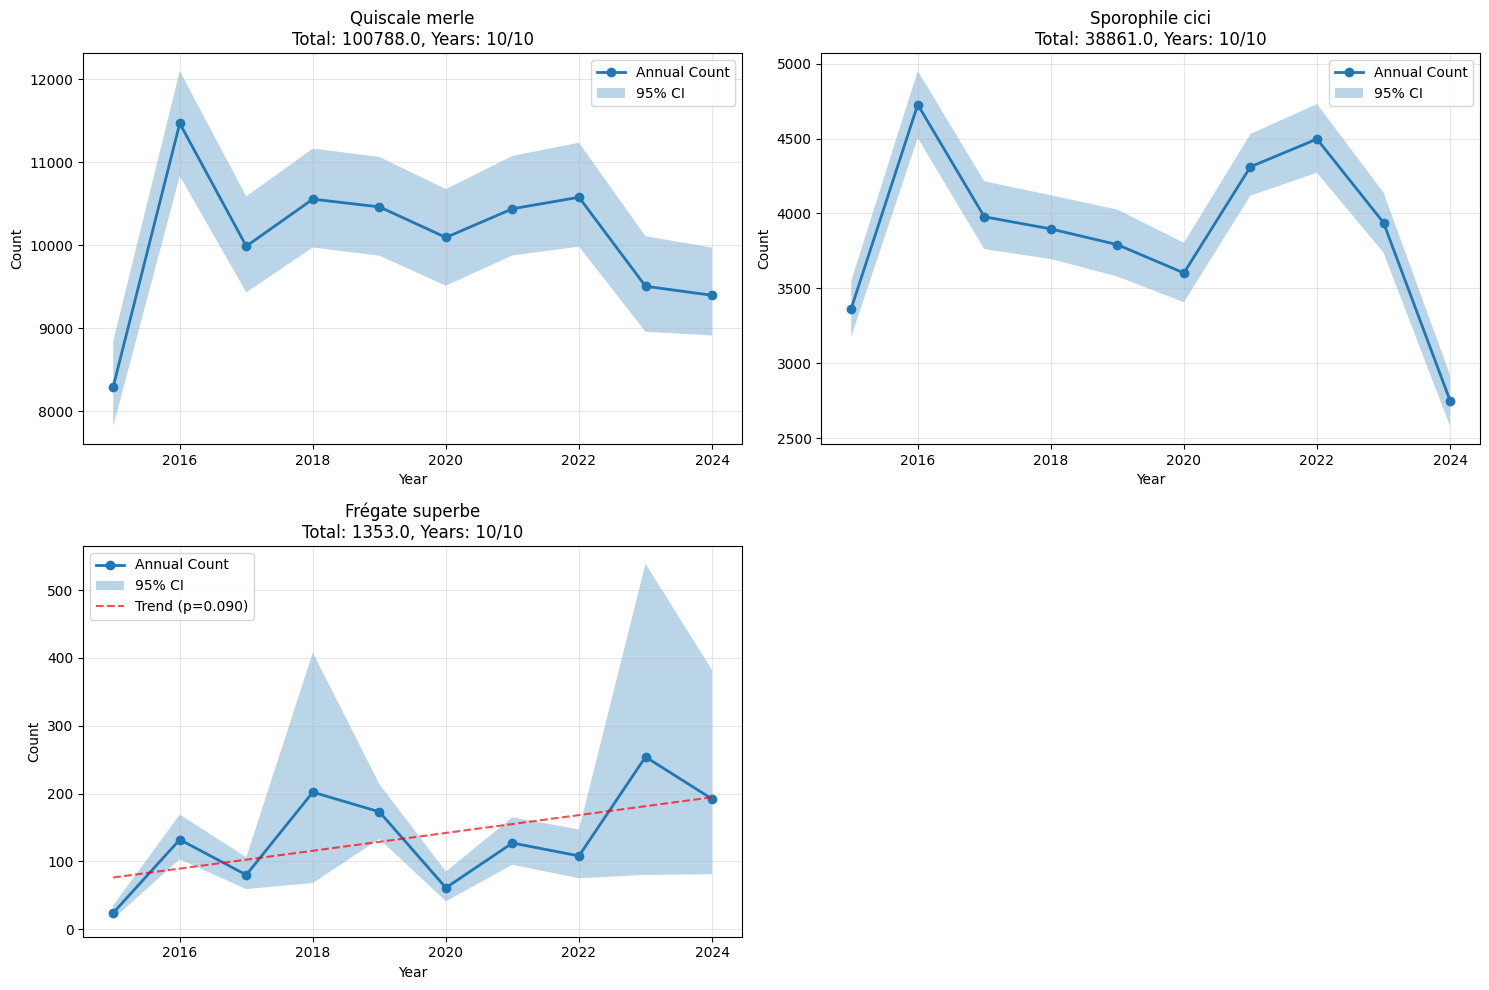

In [59]:
# Cell 3: Create Species Plots 
def create_species_plots(species_results):
    """Create publication-quality plots for each species"""
    
    n_species = len(species_results)
    print(f"Plotting {n_species} species...")
    
    # Dynamically adjust subplot grid based on number of species
    if n_species <= 2:
        fig, axes = plt.subplots(1, 2, figsize=(15, 6))
        axes = axes.flatten()
    elif n_species <= 4:
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
    else:
        # For more than 4 species, create multiple figures
        fig, axes = plt.subplots(2, 2, figsize=(15, 10))
        axes = axes.flatten()
    
    for idx, (species, results) in enumerate(species_results.items()):
        if idx >= len(axes):  # Use actual number of axes available
            break
            
        ax = axes[idx]
        years = results['annual_counts'].index
        counts = results['annual_counts'].values
        
        # Skip if species has no data at all
        if results['total_count'] == 0:
            ax.text(0.5, 0.5, f'{species}\nNo data', 
                   ha='center', va='center', transform=ax.transAxes)
            ax.set_title(f'{species} - No Data')
            continue
        
        # Plot main trend
        ax.plot(years, counts, 'o-', linewidth=2, markersize=6, label='Annual Count')
        
        # Plot confidence intervals (only if we have variation)
        if not np.all(results['ci_lower'] == results['ci_upper']):
            ax.fill_between(years, results['ci_lower'], results['ci_upper'], 
                           alpha=0.3, label='95% CI')
        
        # Add trend line if we have enough data points
        if results['presence_years'] >= 3 and results['trend_p'] < 0.1:
            z = np.polyfit(years, counts, 1)
            p = np.poly1d(z)
            ax.plot(years, p(years), 'r--', alpha=0.7, 
                   label=f'Trend (p={results["trend_p"]:.3f})')
        
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.set_title(f'{species}\nTotal: {results["total_count"]}, Years: {results["presence_years"]}/10')
        ax.legend()
        ax.grid(True, alpha=0.3)
    
    # Hide any unused subplots
    for idx in range(len(species_results), len(axes)):
        axes[idx].set_visible(False)
    
    plt.tight_layout()
    plt.savefig('../figures/species_trends_comparison.png', dpi=300, bbox_inches='tight')
    plt.show()

create_species_plots(species_results)

In [60]:
# Cell 4: Ecological Interpretation (FIXED for Caribbean Birds)
def write_species_interpretations(species_results, df_species):
    """Write ecological interpretations for each species using ACTUAL metadata"""
    
    print("="*60)
    print("SPECIES-LEVEL ECOLOGICAL INTERPRETATIONS")
    print("="*60)
    
    # Caribbean bird ecological knowledge - based on actual Martinique species
    caribbean_ecological_info = {
        'Colibri huppé': 'Antillean endemic hummingbird, common in gardens and forests',
        'Sporophile rougegorge': 'Small seed-eating bird, often in grasslands',
        'Moqueur grivelle': 'Caribbean mockingbird, vocal and territorial',
        'Tyran gris': 'Gray kingbird, common flycatcher, often on power lines',
        'Pigeon à couronne blanche': 'White-crowned pigeon, forest and mangrove species',
        'Petit Blanc': 'Common dove species in open areas',
        'Carouge': 'Blackbird species, often near water and marshes',
        'Merle': 'General thrush species, various habitats',
    }
    
    # Migration status interpretations
    status_interpretations = {
        'Résident': 'Year-round resident, stable populations expected',
        'Migrateur': 'Migratory species, counts may vary with migration timing',
        'Endémique': 'Caribbean endemic, conservation priority',
        'Visiteur': 'Seasonal visitor, irregular presence',
        'Éteint': 'Locally extinct, rare sightings significant',
        'Introduit': 'Non-native species, population dynamics may differ'
    }
    
    for species, results in species_results.items():
        print(f"\n {species}:")
        print(f"   Recorded in {results['presence_years']} out of 10 years")
        print(f"   Total individuals counted: {results['total_count']}")
        
        # Get species metadata from your ESPECES sheet
        species_metadata = get_species_metadata(species, df_species)
        
        if species_metadata:
            print(f"     Scientific name: {species_metadata['scientific_name']}")
            print(f"     Status: {species_metadata['status']}")
            if species_metadata['status'] in status_interpretations:
                print(f"    {status_interpretations[species_metadata['status']]}")
        
        # Ecological context from Caribbean knowledge
        if species in caribbean_ecological_info:
            print(f"    Ecological context: {caribbean_ecological_info[species]}")
        else:
            # Generic interpretation based on patterns
            if results['total_count'] > 100:
                print(f"    Ecological context: Common species in the region")
            elif results['total_count'] < 20:
                print(f"    Ecological context: Rare or elusive species")
        
        # Trend interpretation
        if results['trend_p'] < 0.05:
            direction = "increasing" if results['trend_slope'] > 0 else "decreasing"
            print(f"    Statistically significant {direction} trend (p={results['trend_p']:.3f})")
            
            # Caribbean-specific trend explanations
            if direction == "increasing":
                if species_metadata and species_metadata['status'] == 'Introduit':
                    print(f"      ↳ Typical pattern for introduced species establishing populations")
                else:
                    print(f"      ↳ Could indicate successful adaptation or habitat improvement")
            else:
                print(f"      ↳ May reflect habitat loss or environmental pressures")
                
        else:
            print(f"    No significant trend detected (p={results['trend_p']:.3f})")
            if species_metadata and species_metadata['status'] == 'Résident':
                print(f"      ↳ Expected stability for resident species")
        
        # Limitations discussion - collect all limitations first
        limitations = []
        if results['presence_years'] < 5:
            limitations.append(f"Limited data: only present in {results['presence_years']} years")
        if results['total_count'] < 50:
            limitations.append(f"Low abundance: only {results['total_count']:.0f} total observations")
        if max(results['annual_counts']) < 10:
            limitations.append("Rare species: small counts lead to high uncertainty")
        # Always include general methodological limitations
        if results['trend_p'] > 0.05:
            limitations.append(f"Limited statistical power with 10 years of data (p={results['trend_p']:.3f})")
        if results['presence_years'] == 10 and results['total_count'] > 1000:
            limitations.append("Bootstrap confidence intervals may be narrow due to high counts")
        
        # Only print limitations section if there are any
        if limitations:
            print(f"     Limitations:")
            for lim in limitations:
                print(f"      - {lim}")
        
        # Caribbean-specific considerations - collect all factors first
        caribbean_factors = []
        if species_metadata and species_metadata['status'] == 'Migrateur':
            caribbean_factors.append("Migratory patterns affected by regional climate conditions")
        if species_metadata and species_metadata['status'] == 'Endémique':
            caribbean_factors.append("Endemic species sensitive to local habitat changes")
        if species_metadata and species_metadata['status'] == 'Autochtone':
            caribbean_factors.append("Native species with established populations in Martinique")
        if species_metadata and species_metadata['status'] == 'Marin':
            caribbean_factors.append("Marine-associated species, counts may reflect coastal habitat quality")
        if results['trend_slope'] > 2 and results['trend_p'] < 0.1:
            caribbean_factors.append("Could reflect response to hurricane recovery or habitat restoration")
        elif results['trend_slope'] < -2 and results['trend_p'] < 0.1:
            caribbean_factors.append("May indicate impacts of development or invasive species")
        elif results['trend_p'] > 0.05 and abs(results['trend_slope']) > 10:
            caribbean_factors.append("Large trend magnitude but not statistically significant - may need longer time series")
        
        # Only print Caribbean-specific factors section if there are any
        if caribbean_factors:
            print(f"    Caribbean-specific factors:")
            for factor in caribbean_factors:
                print(f"      - {factor}")

def get_species_metadata(species_name, df_species):
    """Get migration status and other metadata from ESPECES sheet"""
    # Try exact match first
    metadata = df_species[df_species['french_name'] == species_name]
    
    # If no exact match, try partial match (in case of slight naming differences)
    if len(metadata) == 0:
        metadata = df_species[df_species['french_name'].str.contains(species_name, na=False)]
    
    if len(metadata) > 0:
        return {
            'status': metadata['status'].values[0] if 'status' in metadata.columns else 'Unknown',
            'scientific_name': metadata['scientific_name'].values[0] if 'scientific_name' in metadata.columns else 'Unknown'
        }
    return None

# You'll need to call it with your species data:
write_species_interpretations(species_results, data_dict['species'])

SPECIES-LEVEL ECOLOGICAL INTERPRETATIONS

 Quiscale merle:
   Recorded in 10 out of 10 years
   Total individuals counted: 100788.0
     Scientific name: Quiscalus lugubris guadeloupensis
     Status: Autochtone
    Ecological context: Common species in the region
    No significant trend detected (p=0.925)
     Limitations:
      - Limited statistical power with 10 years of data (p=0.925)
      - Bootstrap confidence intervals may be narrow due to high counts
    Caribbean-specific factors:
      - Native species with established populations in Martinique

 Sporophile cici:
   Recorded in 10 out of 10 years
   Total individuals counted: 38861.0
     Scientific name: Melanospiza bicolor ou Tiaris bicolor
     Status: Autochtone
    Ecological context: Common species in the region
    No significant trend detected (p=0.508)
     Limitations:
      - Limited statistical power with 10 years of data (p=0.508)
      - Bootstrap confidence intervals may be narrow due to high counts
    Carib

In [61]:
# Cell 5: Summary and Export
def export_species_results(species_results):
    """Export species-level results for the report"""
    
    summary_data = []
    for species, results in species_results.items():
        summary_data.append({
            'species': species,
            'total_count': results['total_count'],
            'years_present': results['presence_years'],
            'trend_slope': results['trend_slope'],
            'trend_p_value': results['trend_p'],
            'mean_annual_count': results['annual_counts'].mean(),
            'cv_annual_count': results['annual_counts'].std() / results['annual_counts'].mean() * 100
        })
    
    summary_df = pd.DataFrame(summary_data)
    
    # Use relative path and ensure directory exists
    output_path = Path('../results/species_trends_summary.csv')
    output_path.parent.mkdir(parents=True, exist_ok=True)
    summary_df.to_csv(output_path, index=False)
    
    print("\n SPECIES TRENDS SUMMARY:")
    print(summary_df.round(3))
    print(f"\n Results exported to {output_path}")

export_species_results(species_results)

print("\n PART 3 - SPECIES-LEVEL ANALYSIS COMPLETE!")
print("Generated:")
print("  - figures/species_trends_comparison.png")
print("  - results/species_trends_summary.csv")
print("  - Ecological interpretations for each species")


 SPECIES TRENDS SUMMARY:
           species  total_count  years_present  trend_slope  trend_p_value  \
0   Quiscale merle     100788.0             10       -9.697          0.925   
1  Sporophile cici      38861.0             10      -44.794          0.508   
2  Frégate superbe       1353.0             10       13.145          0.090   

   mean_annual_count  cv_annual_count  
0            10078.8            8.526  
1             3886.1           14.663  
2              135.3           52.242  

 Results exported to ../results/species_trends_summary.csv

 PART 3 - SPECIES-LEVEL ANALYSIS COMPLETE!
Generated:
  - figures/species_trends_comparison.png
  - results/species_trends_summary.csv
  - Ecological interpretations for each species


In [62]:
# Cell 6: Presence/Absence Analysis and Logistic Trend
import warnings
warnings.filterwarnings('ignore')
from statsmodels.api import add_constant

print("Presence/absence analysis for selected species...")

# Presence by year (number of rows > 0 implies detected)
presence_by_year = (
    df_clean.groupby(['year', 'species_name'])['individual_count']
            .sum()
            .unstack(fill_value=0)
)
presence_binary = (presence_by_year > 0).astype(int)

presence_trend_results = {}
for species in interesting_species:
    if species not in presence_binary.columns:
        continue
    tmp = presence_binary[[species]].reset_index().rename(columns={species: 'presence'})
    # Fit logistic regression: presence ~ year
    # With few years, keep simple linear term
    X = add_constant(tmp['year'])
    y = tmp['presence']
    try:
        logit_model = sm.Logit(y, X).fit(disp=False)
        slope = float(logit_model.params['year'])
        pval = float(logit_model.pvalues['year'])
        presence_trend_results[species] = {
            'logit_model': logit_model,
            'presence_slope': slope,
            'presence_pvalue': pval,
            'years_detected': int(y.sum()),
            'years_total': int(len(y))
        }
    except Exception as e:
        presence_trend_results[species] = {
            'logit_model': None,
            'presence_slope': np.nan,
            'presence_pvalue': np.nan,
            'years_detected': int(y.sum()),
            'years_total': int(len(y)),
            'error': str(e)
        }

print("\n Presence/absence logistic trend results:")
for sp, res in presence_trend_results.items():
    print(f"- {sp}: slope={res['presence_slope']}, p={res['presence_pvalue']}, detected {res['years_detected']}/{res['years_total']} years")


Presence/absence analysis for selected species...

 Presence/absence logistic trend results:
- Quiscale merle: slope=0.0065444224330575, p=0.9999999990695361, detected 12/12 years
- Sporophile cici: slope=0.0065444224330575, p=0.9999999990695361, detected 12/12 years
- Frégate superbe: slope=0.0065444224330575, p=0.9999999990695361, detected 12/12 years


In [63]:
# Cell 7: Compare Species Trends to Community Richness Trend
print("\nComparing species trends to community richness trend...")

# Community richness (unique species per year)
community_richness = (
    df_clean.groupby('year')['species_name']
            .nunique()
            .sort_index()
)
# Fit linear trend for community richness
X_comm = sm.add_constant(community_richness.index.values)
y_comm = community_richness.values
comm_model = sm.OLS(y_comm, X_comm).fit()
community_richness_slope = float(comm_model.params[1])
community_richness_p = float(comm_model.pvalues[1])

print(f"Community richness slope: {community_richness_slope:.3f} (p={community_richness_p:.3f})")

print("\n🔗 Relationship to Community Trends:")
for species, res in species_results.items():
    species_slope = float(res['trend_slope'])
    print(f"- {species}: species slope={species_slope:.2f}")
    if community_richness_slope > 0 and species_slope > 0:
        print("   → Species likely contributes to community richness increase")
    elif community_richness_slope < 0 and species_slope < 0:
        print("   → Species decline aligns with community decline")
    else:
        print("   → Species trend diverges from community pattern")



Comparing species trends to community richness trend...
Community richness slope: -0.000 (p=1.000)

🔗 Relationship to Community Trends:
- Quiscale merle: species slope=-9.70
   → Species decline aligns with community decline
- Sporophile cici: species slope=-44.79
   → Species decline aligns with community decline
- Frégate superbe: species slope=13.15
   → Species trend diverges from community pattern



Spatial variation analysis by habitat (using GPS-MILIEU metadata)...


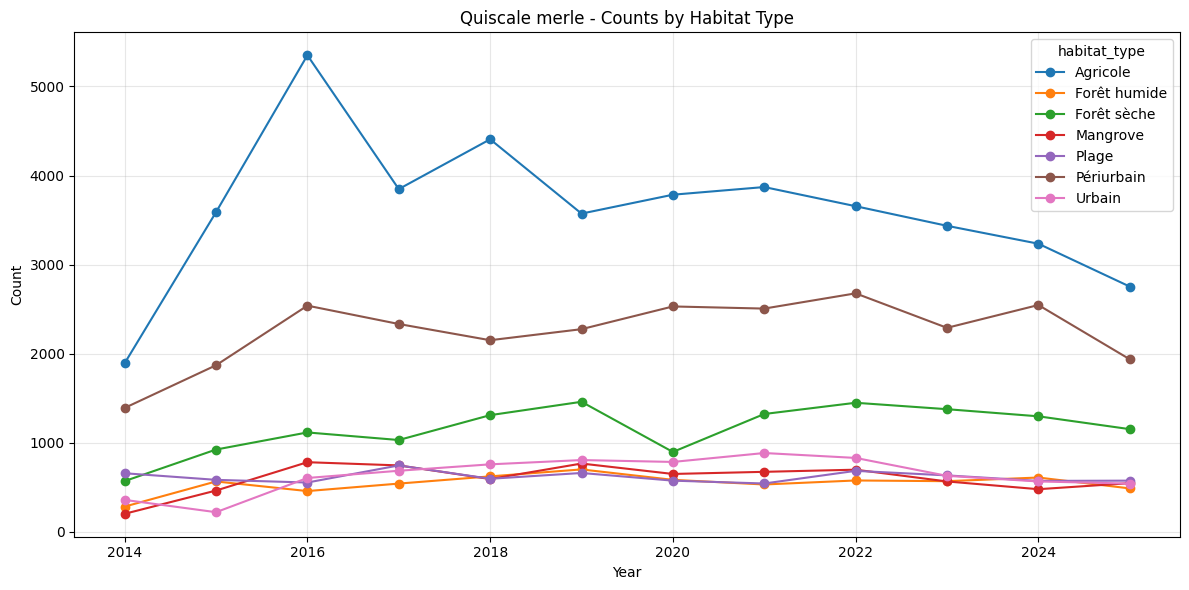

✅ Saved habitat plot for Quiscale merle to ../figures/species_by_habitat_Quiscale_merle.png


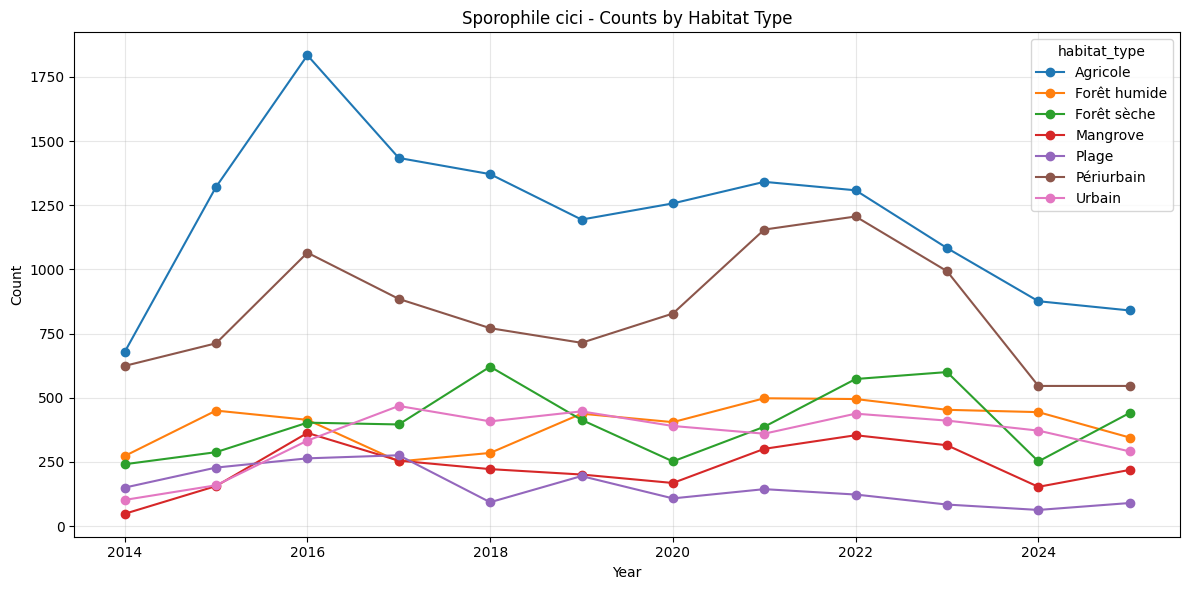

✅ Saved habitat plot for Sporophile cici to ../figures/species_by_habitat_Sporophile_cici.png


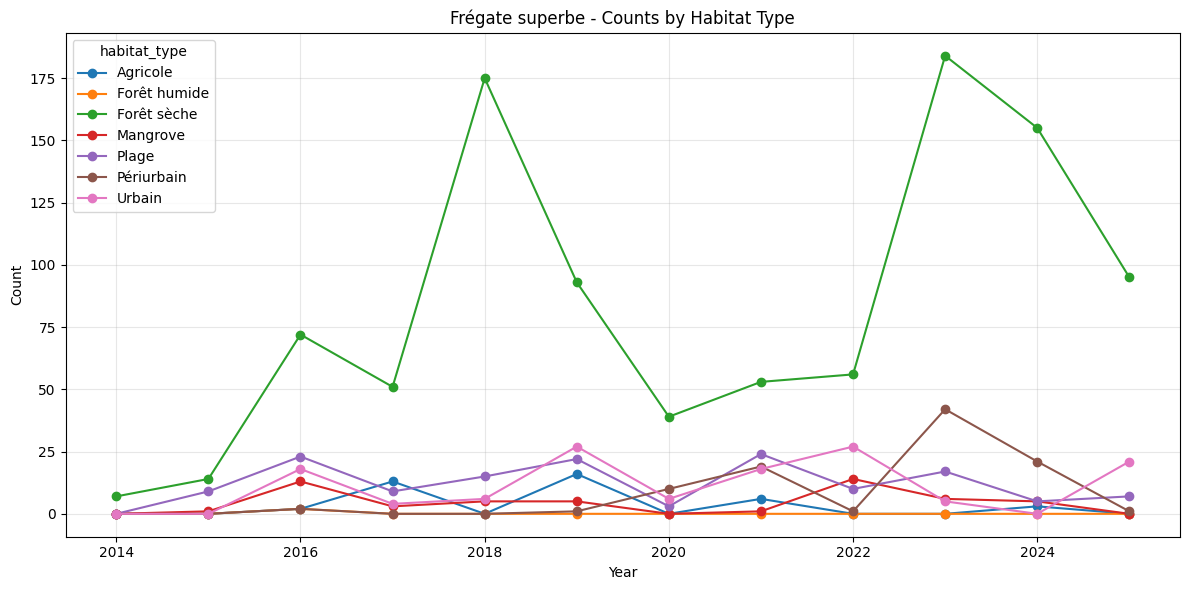

✅ Saved habitat plot for Frégate superbe to ../figures/species_by_habitat_Frégate_superbe.png


In [64]:
# Cell 8: Spatial Variation by Habitat (merge GPS metadata)
print("\nSpatial variation analysis by habitat (using GPS-MILIEU metadata)...")

df_gps = data_dict.get('gps')
if df_gps is None or 'habitat_type' not in df_gps.columns:
    print("GPS metadata with habitat_type not available; skipping habitat analysis.")
else:
    # Keep required columns and de-duplicate
    df_gps_min = df_gps[['transect_name', 'habitat_type']].drop_duplicates()
    # Merge habitat_type onto observations
    df_spatial = df_clean.merge(df_gps_min, on='transect_name', how='left')
    
    for species in interesting_species:
        species_by_habitat = (
            df_spatial[df_spatial['species_name'] == species]
                .groupby(['year', 'habitat_type'])['individual_count']
                .sum()
                .unstack(fill_value=0)
                .sort_index()
        )
        if species_by_habitat.empty:
            print(f"- {species}: no data after merge; skipping plot")
            continue
        
        # Plot trends by habitat
        ax = species_by_habitat.plot(figsize=(12, 6), marker='o')
        ax.set_title(f"{species} - Counts by Habitat Type")
        ax.set_xlabel('Year')
        ax.set_ylabel('Count')
        ax.grid(True, alpha=0.3)
        plt.tight_layout()
        # Save figure to relative figures dir
        out_dir = Path('../figures')
        out_dir.mkdir(parents=True, exist_ok=True)
        out_path = out_dir / f"species_by_habitat_{species.replace(' ', '_')}.png"
        plt.savefig(out_path, dpi=300, bbox_inches='tight')
        plt.show()
        print(f"✅ Saved habitat plot for {species} to {out_path}")


In [65]:
# Cell 9: Observer Effects on Species Detection
print("\nObserver detection rate analysis for selected species...")

observer_effects = {}
for species in interesting_species:
    df_s = df_clean.copy()
    df_s['detected'] = (df_s['species_name'] == species).astype(int)
    # Aggregate by observer
    by_observer = df_s.groupby('observer_name').agg(
        detections=('detected', 'sum'),
        effort=('detected', 'count')
    )
    by_observer['detection_rate'] = by_observer['detections'] / by_observer['effort']
    by_observer = by_observer.sort_values('detection_rate', ascending=False)
    observer_effects[species] = by_observer
    
    print(f"\n- {species}:")
    print("Top observers by detection rate (min 100 observations of any species):")
    filt = by_observer[by_observer['effort'] >= 100]
    print(filt.head(5).round(3))
    
    # Specific check for CONDE Beatriz if present
    target = 'CONDE Beatriz'
    if target in by_observer.index:
        row = by_observer.loc[target]
        print(f"   {target}: detections={int(row['detections'])}, effort={int(row['effort'])}, rate={row['detection_rate']:.3f}")
    else:
        print("   CONDE Beatriz not found in observer list.")



Observer detection rate analysis for selected species...

- Quiscale merle:
Top observers by detection rate (min 100 observations of any species):
                                detections  effort  detection_rate
observer_name                                                     
LABONNE Annick                          69     465           0.148
CUROT-LODEON Elisa                      27     214           0.126
PARSEMAIN Marie Claire                  39     315           0.124
MELOIS Hubert - URSULE Francis         123    1002           0.123
CHANTEUR Bénédicte                      55     504           0.109
   CONDE Beatriz: detections=3479, effort=41779, rate=0.083

- Sporophile cici:
Top observers by detection rate (min 100 observations of any species):
                                detections  effort  detection_rate
observer_name                                                     
HUGUES DESPOINTES Martine              110     981           0.112
LABONNE Annick                 

In [67]:
# Cell 10: Individual High-Quality Plots per Species
print("\nCreating individual plots per species...")

from matplotlib.ticker import FuncFormatter

def create_individual_species_plot(species, results, df_year_totals):
    years = results['annual_counts'].index
    counts = results['annual_counts'].values
    
    # Proportional abundance (%) relative to community
    pct = (results['annual_counts'] / df_year_totals).fillna(0) * 100
    
    fig, ax1 = plt.subplots(figsize=(10, 6))
    ax1.plot(years, counts, marker='o', linewidth=2.5, label='Annual Count')
    ax1.set_xlabel('Year')
    ax1.set_ylabel('Count')
    ax1.grid(True, alpha=0.3)
    
    ax2 = ax1.twinx()
    ax2.plot(years, pct.values, 'g--', linewidth=2, label='% of Community')
    ax2.set_ylabel('% of Community')
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0f}%'))
    
    # Build combined legend
    lines = ax1.get_lines() + ax2.get_lines()
    labels = [l.get_label() for l in lines]
    ax1.legend(lines, labels, loc='upper left')
    
    title_extra = ''
    if results['presence_years'] >= 3:
        title_extra = f" (trend slope: {results['trend_slope']:.2f}, p={results['trend_p']:.3f})"
    ax1.set_title(f"{species}{title_extra}")
    
    plt.tight_layout()
    out_dir = Path('../figures')
    out_dir.mkdir(parents=True, exist_ok=True)
    out_path = out_dir / f"species_{species.replace(' ', '_')}.png"
    plt.savefig(out_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    print(f" Saved {species} to {out_path}")

# Precompute community totals per year for proportional abundance
df_year_totals = (
    df_clean.groupby('year')['individual_count'].sum().reindex(range(2015, 2025)).fillna(0)
)

for sp, res in species_results.items():
    create_individual_species_plot(sp, res, df_year_totals)



Creating individual plots per species...
 Saved Quiscale merle to ../figures/species_Quiscale_merle.png
 Saved Sporophile cici to ../figures/species_Sporophile_cici.png
 Saved Frégate superbe to ../figures/species_Frégate_superbe.png
